The recent rapid surge in the CYBN stock price has prompted me to explore whether such spikes in stock value could have been predicted by analyzing social trends. To investigate this, I embarked on a project where I gathered data from Google Trends (https://trends.google.com/trends/?geo=US), focusing on keywords that might be closely linked to the growth of specific stocks. For this particular study, my focus is on the emerging market for the commercialization of Psylocybin products in the United States.

The overarching goal of this project is to develop a predictive model that can be applied to various stocks with significant media correlations. By doing so, we aim to gain insights into whether social trends and keyword searches can serve as indicators for potential stock price movements.

           week  search_volume
0    2018-09-30           63.0
1    2018-10-07           66.0
2    2018-10-14           52.0
3    2018-10-21           66.0
4    2018-10-28           58.0
..          ...            ...
255  2023-08-20          248.0
256  2023-08-27          282.0
257  2023-09-03          211.0
258  2023-09-10          273.0
259  2023-09-17          475.0

[260 rows x 2 columns]


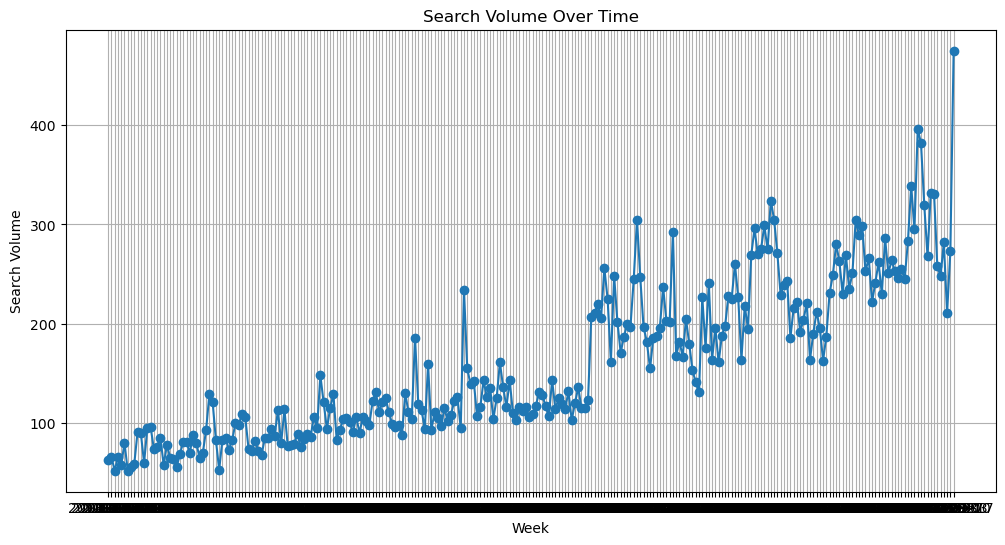

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
import numpy as np

#import dataframes from csv files
keyword1 = pd.read_csv('CYBN.csv')
keyword2 = pd.read_csv('magic_mushrooms.csv')
keyword3 = pd.read_csv('psylocibin_therapy.csv')
keyword4 = pd.read_csv('psylocibin.csv')
keyword5 = pd.read_csv('shrooms.csv')

#Create a volume index by merging the dataframes
weight1=3.0 
index=[keyword1,keyword2,keyword3,keyword4,keyword5]
index[0]['search_volume'] *=weight1 #More weight is given to the keyword referring to the Stock's name
volume_index=pd.concat(index)
volume_index.set_index('week', inplace=True)
volume_index=volume_index.groupby('week')['search_volume'].sum().reset_index()
print(volume_index)

plt.figure(figsize=(12, 6))
plt.plot(volume_index['week'], volume_index['search_volume'], marker='o', linestyle='-')
plt.title('Search Volume Over Time')
plt.xlabel('Week')
plt.ylabel('Search Volume')
plt.grid(True)
plt.show()



Once this data has been gathered in our index, let's develop a simple prediction model using Machine Learning (torch).

[*********************100%%**********************]  1 of 1 completed
MSE: 0.31434783567971836
Predicted price one month into the future: 1.981501579284668, ie price as of 2023-09-25 00:00:00


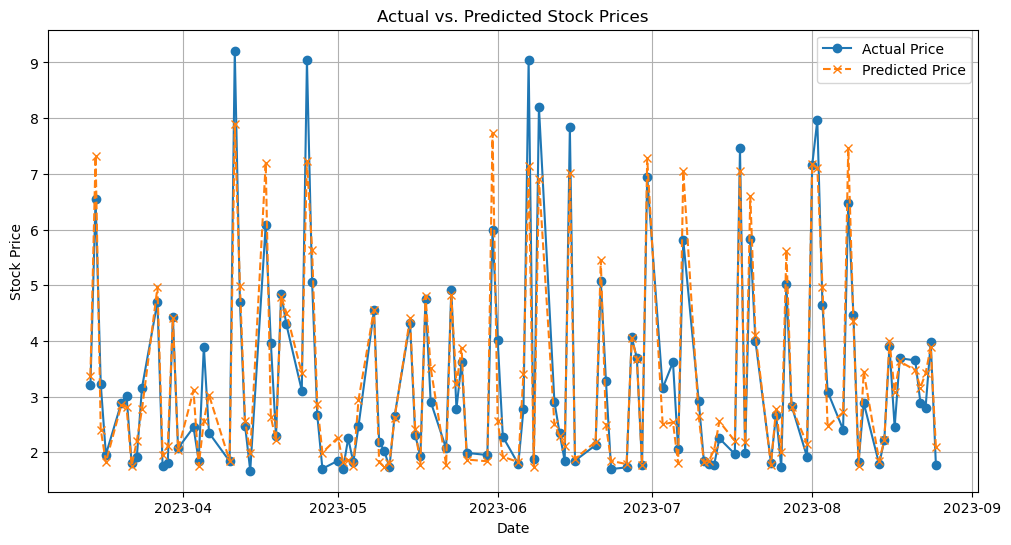

In [68]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#Set the number of months to predict
num_months = 1
# Load stock data (Select a stock related to the keyword)
#stock_data = yf.download('PSIL', start='2021-01-01', end='2023-08-26')
#stock_data = yf.download('JNJ', start='2021-01-01', end='2023-08-26')
stock_data = yf.download('CYBN', start='2021-01-01', end='2023-08-26')
#stock_data = yf.download('MNMD', start='2021-01-01', end='2023-08-26') 
#stock_data = yf.download('PMD', start='2021-01-01', end='2023-08-26')

end1 = stock_data.index[-1] + pd.DateOffset(months=num_months)
# Extract the 'Close' prices of a given stock
prices = stock_data['Close'].values.reshape(-1, 1)
# Normalize the data
scaler = MinMaxScaler()
prices_normalized = scaler.fit_transform(prices)
# Create a dataset for training
X = prices_normalized[:-(30*num_months)]  # Data up to one month before the end
y = prices_normalized[(30*num_months):]    # Stock price one month later
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).view(-1, 1)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
# Define a linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)  
    def forward(self, x):
        return self.linear(x)
    
model = LinearRegressionModel()
# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad() # Clear gradients from previous iteration
    outputs = model(X_train_tensor) # Forward pass
    loss = criterion(outputs, y_train_tensor) 
    loss.backward() # Calculate gradients
    optimizer.step()
# Make predictions for the test set
X_test_tensor = torch.FloatTensor(X_test).view(-1, 1)
predictions = model(X_test_tensor)
# Convert predictions and test data back to their original scale
predictions = scaler.inverse_transform(predictions.detach().numpy()) 
y_test = scaler.inverse_transform(y_test) 
# Evaluate the model
mse = mean_squared_error(y_test, predictions) 
print(f"MSE: {mse}")
# Predict the price one month into the future
last_price = torch.FloatTensor(prices_normalized[-30]).view(1, -1)
predicted_price_normalized = model(last_price)
predicted_price = scaler.inverse_transform(predicted_price_normalized.detach().numpy())[0][0]
print(f"Predicted price one month into the future: {predicted_price}, ie price as of {end1}")
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index[-len(y_test):], y_test, label='Actual Price', marker='o', linestyle='-')
plt.plot(stock_data.index[-len(predictions):], predictions, label='Predicted Price', marker='x', linestyle='--')
plt.title('Actual vs. Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()